<br>
<font>
<!-- <img src="https://sina.sharif.edu/~m_salehi/images/logo_sharif.png" alt="SUT logo" width=300 height=300 align=left class="saturate"> -->
<div dir=ltr align=center>
<img src="https://sina.sharif.edu/~m_salehi/images/logo_sharif.png" width=160 height=180>
<br>
<font color=0F5298 size=6>
Introduction to Machine Learning <br>
<font color= 6C3BAA size=6>
Logistic Regression <br>
<font color=696880 size=5>
<!-- <br> -->
Computer Engineering Department
<br>
Sharif University of Technology

<font color=696880 size=5>
<br>
CE 40477 - Fall 2025

<font color=GREEN size=5>
<br>
Mahdi Aghaei & Farzan Rahmani
<!-- <br> -->

____


# Table of Contents


*   ## [Binary Classification](#scrollTo=rwBQ-Xn1xc-6)
*   ## [Multi-class logistic regression](#scrollTo=ebx9kaEpwpOd&line=1&uniqifier=1)
*  ## [Real-World Example: Pima Indians Diabetes](#scrollTo=rK2ukkrQtTGh&line=1&uniqifier=1)


# Binary Classification
In this section, we will use [breast cancer dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html) of scikit-learn which is a classic binary classification dataset used for machine learning. This dataset contains multiple features for tumors as well as it's label (either benign or malignant).

At first the dataset is loaded from Scikit-learn’s built-in load_breast_cancer function, which provides features and labels for tumor samples. After extracting the features (X) and labels (y), the feature names are printed to understand what variables are available.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns

# Load breast cancer dataset
data = load_breast_cancer()

# Extract features and labels
X = data.data
y = data.target

print(data.feature_names)

['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


Next, we focus our analysis on two specific features — **mean perimeter** and **mean smoothnes** — to make the classification problem visually interpretable. We standardize these features to ensure consistent scaling, add a bias term manually, and then divide the dataset into training and validation sets with an 80/20 ratio. A scatter plot of the training data helps us see how the two tumor classes are distributed across the selected features.

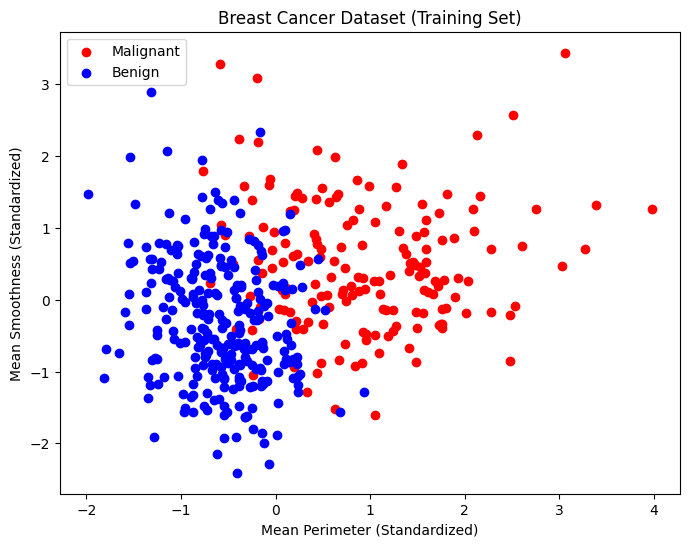

In [ ]:
# Select two features (mean perimeter and mean smoothness)
X = data.data[:, [2, 4]]

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Add bias term (column of ones)
X_bias = np.hstack((X, np.ones((X.shape[0], 1))))

# Split data into training and validation sets (80/20)
X_train, X_val, y_train, y_val = train_test_split(
    X_bias, y, test_size=0.2, random_state=42, stratify=y
)

# Plot training data
plt.figure(figsize=(8, 6))
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1],
            color='red', label='Malignant')
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1],
            color='blue', label='Benign')
plt.xlabel('Mean Perimeter (Standardized)')
plt.ylabel('Mean Smoothness (Standardized)')
plt.title('Breast Cancer Dataset (Training Set)')
plt.legend()
plt.show()

Know we define core functions required for logistic regression.

We implement the **sigmoid activation function**, the **binary cross-entropy loss function**, the **gradient of the loss,** and a **function to compute validation accuracy** :

Sigmoid : $
\sigma(z) = \frac{1}{1 + e^{-z}}
$


Loss: $
L(w) = -\frac{1}{m} \sum_{i=1}^{m} \Big[ y^{(i)} \log(\hat{y}^{(i)}) + (1 - y^{(i)}) \log(1 - \hat{y}^{(i)}) \Big]
$
&nbsp; &nbsp; s.t &nbsp; &nbsp;
$
\hat{y}^{(i)} = \sigma(X^{(i)} w)
$

Gradient:
$
\nabla_w L(w) = \frac{1}{m} X^{T} (\hat{y} - y)
$

Accuracy:
$
\text{Accuracy} = \frac{1}{m} \sum_{i=1}^{m} \mathbb{I}\big[ \hat{y}^{(i)} = y^{(i)} \big]
$
&nbsp; &nbsp; s.t &nbsp; &nbsp;
$
\hat{y}^{(i)} =
\begin{cases}
1 & \text{if } \sigma(X^{(i)} w) > 0.5 \\
0 & \text{o.w}
\end{cases}
$

In [ ]:
# Sigmoid activation function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Compute logistic regression loss (binary cross-entropy)
def compute_loss(w, X, y):
    z = X @ w
    predictions = sigmoid(z)
    loss = -np.mean(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))
    return loss

# Compute gradient of the loss weights
def compute_gradient(w, X, y):
    z = X @ w
    predictions = sigmoid(z)
    errors = predictions - y
    gradient = X.T @ errors / len(y)
    return gradient

# Evaluate validation accuracy
def validation_accuracy(w, X_val, y_val):
    probabilities = sigmoid(X_val @ w)
    predictions = (probabilities > 0.5).astype(int)
    accuracy = np.mean(predictions == y_val)
    return accuracy

Moving on, we implement gradient descent as the optimization algorithm that updates model weights iteratively. Starting with zeros, we repeatedly compute the gradient, adjust the weights, and monitor the loss and accuracy over time. The process logs progress every hundred steps and halts early if the improvement in loss becomes minimal, ensuring efficiency and stability during training.

In [ ]:
# Gradient descent for logistic regression
def gradient_descent_logistic(X_train, y_train, X_val, y_val, learning_rate=0.1, n_steps=1000, tolerance=1e-6):
    # Initialize weights
    w = np.zeros(X_train.shape[1])
    # Track loss, accuracy, and weights
    loss_history = [compute_loss(w, X_train, y_train)]
    val_accuracy_history = [validation_accuracy(w, X_val, y_val)]
    weights_history = [w.copy()]

    # Main training loop
    for step in range(1, n_steps + 1):
        grad = compute_gradient(w, X_train, y_train)
        w -= learning_rate * grad  # Update weights

        loss = compute_loss(w, X_train, y_train)
        loss_history.append(loss)

        acc = validation_accuracy(w, X_val, y_val)
        val_accuracy_history.append(acc)

        # Save weights every 10 steps
        if step % 10 == 0:
            weights_history.append(w.copy())

        # Check for convergence
        if np.abs(loss_history[-2] - loss_history[-1]) < tolerance:
            print(f'Converged at step {step}')
            break

        # Log progress every 100 steps
        if step % 100 == 0:
            print(f'Step {step}: Loss = {loss:.4f}, Validation Accuracy = {acc:.4f}')

    return w, loss_history, val_accuracy_history, weights_history

We set the **learning rate** and **number of training iterations**, run the gradient descent algorithm, and print the optimized weights:

In [ ]:
# Set learning rate and number of steps
learning_rate = 0.05
n_steps = 800

# Train logistic regression model with gradient descent
w_opt, loss_history, val_accuracy_history, weights_history = gradient_descent_logistic(
    X_train, y_train, X_val, y_val,
    learning_rate=learning_rate,
    n_steps=n_steps,
)

print(f'Optimized weights: {w_opt}')
print(f'Decision rule: {w_opt[0]} * Mean Perimeter + {w_opt[1]} * Mean Smoothness + {w_opt[2]} > 0 : Benign')
print(f'Decision rule: {w_opt[0]} * Mean Perimeter + {w_opt[1]} * Mean Smoothness + {w_opt[2]} < 0 : Malignant')


Step 100: Loss = 0.3581, Validation Accuracy = 0.8860
Step 200: Loss = 0.2903, Validation Accuracy = 0.8860
Step 300: Loss = 0.2615, Validation Accuracy = 0.8860
Step 400: Loss = 0.2455, Validation Accuracy = 0.8860
Step 500: Loss = 0.2353, Validation Accuracy = 0.8860
Step 600: Loss = 0.2283, Validation Accuracy = 0.8860
Step 700: Loss = 0.2232, Validation Accuracy = 0.8860
Step 800: Loss = 0.2193, Validation Accuracy = 0.8860
Optimized weights: [-2.91812905 -1.07565575  0.59294996]
Decision rule: -2.918129049544554 * Mean Perimeter + -1.075655751703045 * Mean Smoothness + 0.5929499602501579 > 0 : Benign
Decision rule: -2.918129049544554 * Mean Perimeter + -1.075655751703045 * Mean Smoothness + 0.5929499602501579 < 0 : Malignant


We also visualize how the decision boundary evolves as the model learns. By plotting the decision line at different stages of training, with gradually increasing opacity, we illustrate how the classifier progressively refines its separation between malignant and benign samples.

/tmp/ipython-input-3913014356.py:13: RuntimeWarning: invalid value encountered in scalar divide
  plt.axvline(x=-w[2] / w[0], color='green')


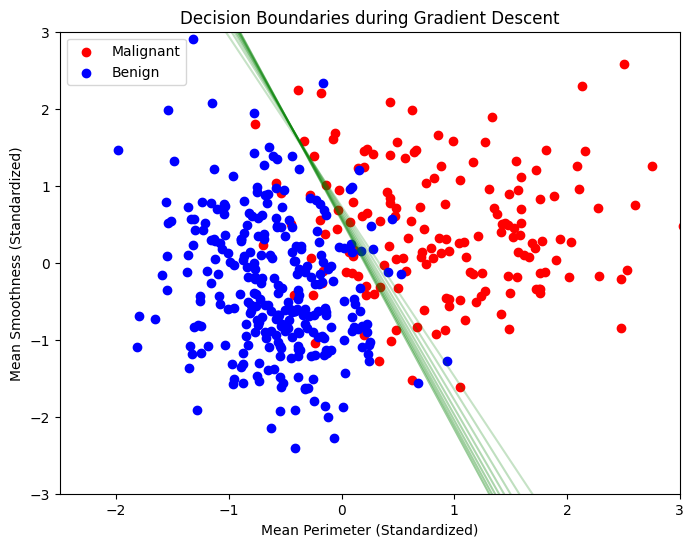

In [ ]:
# Plot a single decision boundary for given weights
def plot_decision_boundary(w, X, y, step, total_steps):
    x_values = np.array([X[:, 0].min() - 1, X[:, 0].max() + 1])

    # Compute corresponding y-values for the boundary
    if w[1] != 0:
        y_values = -(w[0] * x_values + w[2]) / w[1]
        # Draw boundary with increasing opacity over steps
        plt.plot(x_values, y_values, color='green',
                 alpha=(0.20 + (step / total_steps) * 0.20))
    else:
        # Vertical line if w[1] == 0
        plt.axvline(x=-w[2] / w[0], color='green')

    plt.legend()


# Plot all decision boundaries throughout training
def plot_decision_boundaries(weights_history, X, y, total_steps):

    plt.figure(figsize=(8, 6))

    # Plot data points by class
    plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', label='Malignant')
    plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', label='Benign')

    # Set plot limits
    plt.xlim(-2.5, 3)
    plt.ylim(-3, 3)

    # Plot decision boundaries for selected training steps
    for i, w in enumerate(weights_history):
        if i % 10 == 0:
            step = i * 10
            plot_decision_boundary(w, X, y, step, total_steps)

    plt.title('Decision Boundaries during Gradient Descent')
    plt.xlabel('Mean Perimeter (Standardized)')
    plt.ylabel('Mean Smoothness (Standardized)')
    plt.show()


plot_decision_boundaries(weights_history, X_train[:, :2], y_train, n_steps)

The plot above shows that decision boundary is trying to classify data points better at each step. Let's visualize model performance using several metrics. <br> Finally, we evaluate the trained model’s performance on the validation set. Predicted probabilities are transformed into class labels, and we generate a detailed classification report summarizing **precision**, **recall**, and **F1-scores** for each class. We visualize the **confusion matrix** to see misclassifications clearly, then compute and plot the **ROC curve and the AUC (Area Under the Curve)** metric to measure the model’s ability to distinguish between classes. Altogether, these results give us a clear view of how effectively our logistic regression model performs in identifying cancer malignancy :
<div align="center">

| Metric   | &nbsp; &nbsp;  &nbsp; &nbsp; ‌‌‌‌‌‌‌‌‌‌‌ Formula‌‌‌‌‌‌‌‌‌‌ &nbsp; &nbsp;&nbsp; &nbsp; | Focus | Typical Use-Case |
|-----------|-------------|--------|------------------|
| Accuracy  | <div align="center">$\frac{TP + TN}{TP + FP + FN + TN}$</div> | Overall correctness | Balanced classes |
| Precision | <div align="center">$\frac{TP}{TP + FP}$</div> | False positive control | Spam detection, IR |
| Recall    | <div align="center">$\frac{TP}{TP + FN}$</div> | False negative control | Medical diagnosis, anomaly detection |
| F1-Score  | <div align="center">$\frac{2PR}{P + R}$</div> | Balance | Imbalanced or skewed datasets |
</div>
<br> <br>
<img src="https://miro.medium.com/v2/0*P7ZXAWS1QJl9k7h1" width=460 height=250>
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;
<img src="https://www.mathworks.com/help/examples/nnet/win64/CompareDeepLearningModelsUsingROCCurvesExample_01.png" width=340 height=250>




              precision    recall  f1-score     support
Malignant      0.837209  0.857143  0.847059   42.000000
Benign         0.915493  0.902778  0.909091   72.000000
accuracy       0.885965  0.885965  0.885965    0.885965
macro avg      0.876351  0.879960  0.878075  114.000000
weighted avg   0.886652  0.885965  0.886237  114.000000
Accuracy: 0.8860


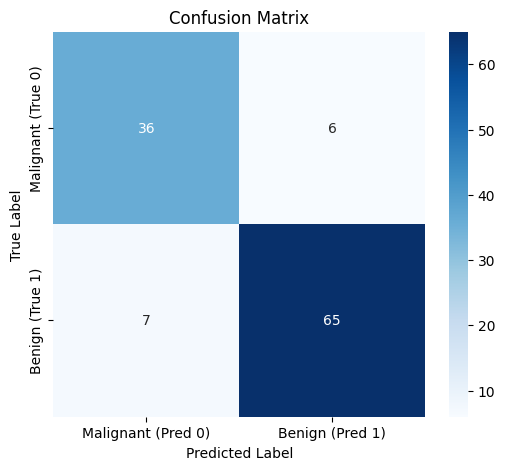

ROC Curve Analysis
Area Under the Curve (AUC): 0.9613


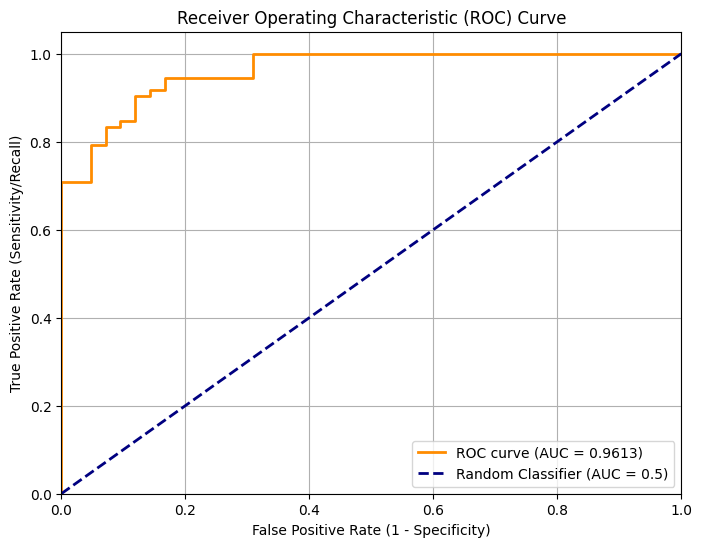

In [ ]:
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
import pandas as pd

# Compute model outputs and predictions on validation set
z_val = X_val @ w_opt
probabilities_val = sigmoid(z_val)
predictions_val = (probabilities_val > 0.5).astype(int)

# Generate classification report
report = classification_report(y_val, predictions_val, target_names=['Malignant', 'Benign'], output_dict=True)
df_report = pd.DataFrame(report).transpose()
print(df_report)

# Extract and print overall accuracy
accuracy = report['accuracy']
print(f"Accuracy: {accuracy:.4f}")

# Compute and plot confusion matrix
cm = confusion_matrix(y_val, predictions_val)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Malignant (Pred 0)', 'Benign (Pred 1)'],
            yticklabels=['Malignant (True 0)', 'Benign (True 1)'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_val, probabilities_val)
roc_auc = auc(fpr, tpr)

print("ROC Curve Analysis")
print(f"Area Under the Curve (AUC): {roc_auc:.4f}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
         label='Random Classifier (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity/Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

#Multi-class logistic regression
We develop a multi-class logistic regression model (softmax regression) to classify flowers from the Iris dataset into three species — setosa, versicolor, and virginica. Our approach covers the entire process, from data loading and feature selection to mathematical formulation, training, visualization of decision boundaries, and performance evaluation, all implemented from scratch using NumPy.

Now we start by loading the Iris dataset using Scikit-learn’s built-in load_iris() function. From the full set of four features, we select only petal length and petal width, as these two provide the clearest separation between the species. The selected features are standardized for consistent scaling across dimensions, and a bias term (a column of ones) is added to the data matrix to account for the intercept in the linear model. To visualize the dataset, we plot the standardized features in a scatter plot, where each class is shown in a different color, clearly illustrating how the three flower types are distributed in feature space.

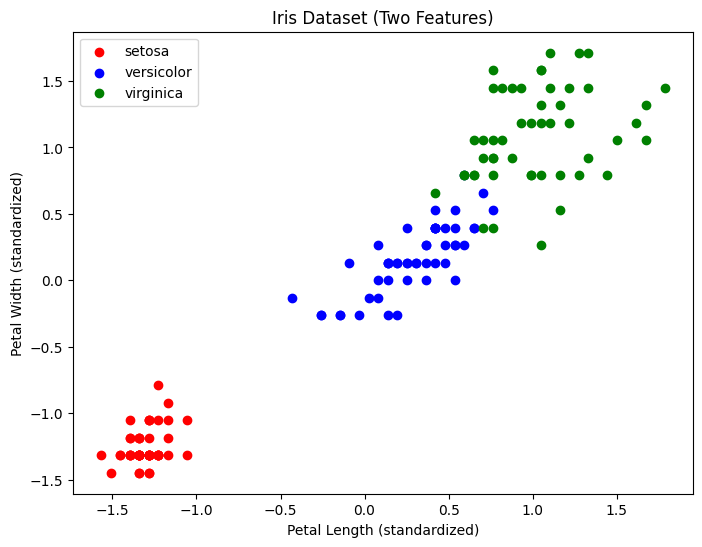

In [ ]:
from sklearn.datasets import load_iris

# Load Iris dataset
data = load_iris()
X = data.data
y = data.target

# Select two features (petal length and petal width)
feature_indices = [2, 3]
X = X[:, feature_indices]

# Standardize selected features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Add bias term (column of ones)
X_bias = np.hstack((X_scaled, np.ones((X_scaled.shape[0], 1))))

# Plot standardized features by class
plt.figure(figsize=(8, 6))
colors = ['red', 'blue', 'green']
labels = data.target_names

for i in range(len(colors)):
    plt.scatter(X_scaled[y == i, 0], X_scaled[y == i, 1], color=colors[i], label=labels[i])

plt.xlabel('Petal Length (standardized)')
plt.ylabel('Petal Width (standardized)')
plt.title('Iris Dataset (Two Features)')
plt.legend()
plt.show()

Let us define softmax and GD as well:

In [ ]:
# Softmax activation function
def softmax(z):
    exp_z = np.exp(z)
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

# Compute cross-entropy loss for multi-class classification
def compute_loss_multiclass(w, X, y):
    z = X @ w
    predictions = softmax(z)

    n_samples, n_classes = predictions.shape
    # One-hot encode labels
    y_onehot = np.zeros((n_samples, n_classes))
    y_onehot[np.arange(n_samples), y] = 1

    # Add small epsilon for numerical stability
    epsilon = 1e-15
    loss = -np.mean(np.sum(y_onehot * np.log(predictions + epsilon), axis=1))
    return loss

# Compute gradient of multi-class loss weights
def compute_gradient_multiclass(w, X, y):
    z = X @ w
    predictions = softmax(z)
    n_samples, n_classes = predictions.shape
    y_onehot = np.zeros((n_samples, n_classes))
    y_onehot[np.arange(n_samples), y] = 1
    errors = predictions - y_onehot
    gradient = X.T @ errors / len(y)
    return gradient

# Compute accuracy for multi-class classification
def multiclass_accuracy(w, X, y):
    probabilities = softmax(X @ w)
    predictions = np.argmax(probabilities, axis=1)
    accuracy = np.mean(predictions == y)
    return accuracy

# Gradient descent for multi-class logistic regression (softmax regression)
def gradient_descent_multiclass(X, y, learning_rate=0.1, n_steps=10000, tolerance=1e-6):
    n_features = X.shape[1]
    n_classes = np.max(y) + 1

    # Initialize weights
    w = np.zeros((n_features, n_classes))
    loss_history = [compute_loss_multiclass(w, X, y)]
    weights_history = [w.copy()]

    # Training loop
    for step in range(1, n_steps + 1):
        grad = compute_gradient_multiclass(w, X, y)
        w -= learning_rate * grad  # Update weights
        loss = compute_loss_multiclass(w, X, y)
        loss_history.append(loss)

        # Save weights periodically
        if step % 10 == 0:
            weights_history.append(w.copy())

        # Stop if loss change is below tolerance
        if np.abs(loss_history[-2] - loss_history[-1]) < tolerance:
            print(f'Converged at step {step}')
            break

        # Print progress every 1000 steps
        if step % 1000 == 0:
            acc = multiclass_accuracy(w, X, y)
            print(f'Step {step}: Loss = {loss:.4f}, Training Accuracy = {acc:.4f}')

    return w, loss_history, weights_history

# Train model and evaluate
w, loss_history, weights_history = gradient_descent_multiclass(X_bias, y)

# Final accuracy on training data
final_accuracy = multiclass_accuracy(w, X_bias, y)
print(f'\nFinal Training Accuracy: {final_accuracy:.4f}')

Step 1000: Loss = 0.1367, Training Accuracy = 0.9533
Step 2000: Loss = 0.1070, Training Accuracy = 0.9533
Step 3000: Loss = 0.0953, Training Accuracy = 0.9533
Step 4000: Loss = 0.0889, Training Accuracy = 0.9533
Step 5000: Loss = 0.0848, Training Accuracy = 0.9600
Step 6000: Loss = 0.0819, Training Accuracy = 0.9600
Step 7000: Loss = 0.0798, Training Accuracy = 0.9600
Step 8000: Loss = 0.0782, Training Accuracy = 0.9600
Step 9000: Loss = 0.0769, Training Accuracy = 0.9600
Converged at step 9646

Final Training Accuracy: 0.9600


We visualize the decision boundaries produced by the trained softmax regression model. Using a dense grid of feature values, we apply the model to predict the most probable class for each point, creating a color-coded map that shows which regions of the feature space correspond to each flower species. On top of this map, we plot the actual data points, helping us see how well the learned boundaries separate the three classes. We also visualize the loss history over training iterations, which typically shows a smooth downward trend as the model converges.

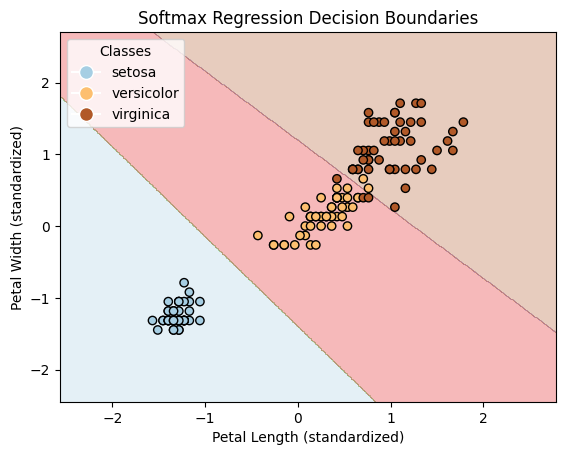

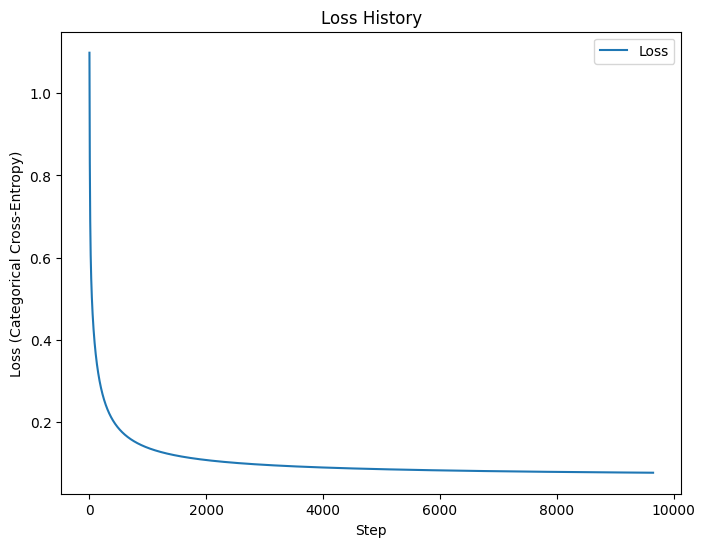

In [ ]:
# Plot decision boundaries for multi-class softmax regression
def plot_decision_boundaries_multiclass(X, y, w, target_names):
    # Define grid limits
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    X_grid = np.c_[xx.ravel(), yy.ravel(), np.ones(xx.ravel().shape[0])]
    Z = np.argmax(softmax(X_grid @ w), axis=1)
    Z = Z.reshape(xx.shape)

    # Plot decision regions
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Paired)

    # Plot data points
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)

    # Create legend with class labels
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', label=target_names[i],
                   markerfacecolor=scatter.to_rgba(i), markersize=10)
        for i in range(len(target_names))
    ]

    plt.xlabel('Petal Length (standardized)')
    plt.ylabel('Petal Width (standardized)')
    plt.title('Softmax Regression Decision Boundaries')
    plt.legend(handles=legend_elements, title="Classes")
    plt.show()

plot_decision_boundaries_multiclass(X_scaled, y, w, data.target_names)

plt.figure(figsize=(8, 6))
plt.plot(loss_history, label='Loss')
plt.xlabel('Step')
plt.ylabel('Loss (Categorical Cross-Entropy)')
plt.title('Loss History')
plt.legend()
plt.show()


Finally, we evaluate the model’s performance more formally using a confusion matrix. By comparing predicted labels against true labels, we visualize which classes are being correctly identified and where the model makes mistakes. The matrix is displayed as a heatmap, with each axis labeled by the flower species, allowing us to easily assess strengths and weaknesses in the classifier’s predictions.

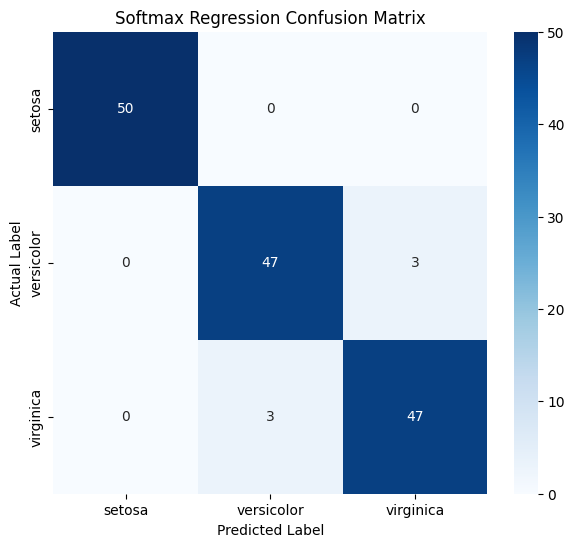

In [ ]:
# Plot confusion matrix for multi-class softmax regression
def plot_confusion_matrix_multiclass(w, X, y, target_names):
    # Compute class probabilities and predictions
    probabilities = softmax(X @ w)
    predictions = np.argmax(probabilities, axis=1)

    # Generate confusion matrix
    cm = confusion_matrix(y, predictions)
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names,
                yticklabels=target_names)
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.title('Softmax Regression Confusion Matrix')
    plt.show()

plot_confusion_matrix_multiclass(w, X_bias, y, data.target_names)

#Real-World Example: Pima Indians Diabetes
In this section, we apply logistic regression with gradient descent to the Pima Indians Diabetes dataset, aiming to predict whether a person has diabetes based on diagnostic measurements. The workflow includes dataset loading, preprocessing, training, evaluation, and visualization of model performance metrics, all built upon a custom logistic regression implementation rather than Scikit-learn’s built-in estimator.

We begin by attempting to load the Pima Indians Diabetes dataset from OpenML. This dataset contains eight medical features — such as glucose level, BMI, and age — along with a binary target indicating diabetes presence. To ensure compatibility, we check whether the target labels are stored as strings and, if so, map them to numeric values (0 and 1). <br> In case of a loading or conversion error, we fall back to a randomly generated placeholder dataset for demonstration purposes. After loading, we print the dataset’s shape and feature names to confirm successful setup.

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.metrics import classification_report

try:
    # Load the Pima Indians Diabetes dataset from OpenML
    diabetes_data = fetch_openml(name='pima-indians-diabetes', version=1, as_frame=False)
    X_new = diabetes_data.data
    y_new = diabetes_data.target

    # Convert string labels to binary (0/1) if necessary
    if y_new.dtype == object or y_new.dtype.kind == 'U':
        unique_labels = np.unique(y_new)
        if len(unique_labels) == 2:
            label_map = {unique_labels[0]: 0, unique_labels[1]: 1}
            y_new = np.array([label_map[label] for label in y_new])
        else:
            raise ValueError("Labels are not clearly binary or mapping failed.")

# Handle data loading or conversion errors
except Exception as e:
    print(f"Error encountered: {e}. Using a placeholder random dataset for demonstration.")
    X_new = np.random.rand(500, 8)
    y_new = np.random.randint(0, 2, 500)

print(f"Dataset shape: X={X_new.shape}, y={y_new.shape}")
print(f"Feature Names: Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age")

Dataset shape: X=(768, 8), y=(768,)
Feature Names: Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age


Next, we explore the data visually by plotting glucose level against BMI, coloring the points by diabetes status. This scatter plot provides an intuitive first look at how these two features relate to the outcome. Individuals with higher glucose and BMI values often cluster in the diabetic group, while those with lower values tend to belong to the non-diabetic group.

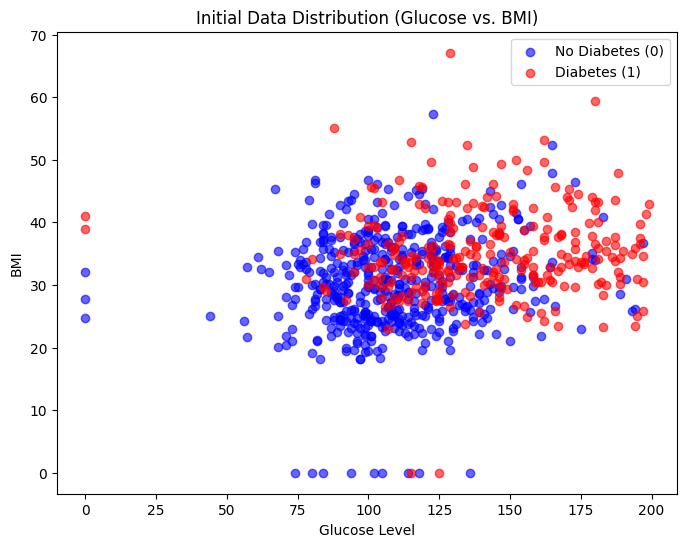

In [ ]:
# Scatter plot of Glucose vs BMI colored by diabetes status
plt.figure(figsize=(8, 6))
plt.scatter(X_new[y_new == 0, 1], X_new[y_new == 0, 5], color='blue', alpha=0.6, label='No Diabetes (0)')
plt.scatter(X_new[y_new == 1, 1], X_new[y_new == 1, 5], color='red', alpha=0.6, label='Diabetes (1)')
plt.xlabel('Glucose Level')
plt.ylabel('BMI')
plt.title('Initial Data Distribution (Glucose vs. BMI)')
plt.legend()
plt.show()

Now we should handle data preprocessing and model training setup:

In [ ]:
# Standardize features
scaler_new = StandardScaler()
X_new = scaler_new.fit_transform(X_new)

# Add bias term (column of ones)
X_new_bias = np.hstack((X_new, np.ones((X_new.shape[0], 1))))

# Split dataset into training and validation sets (75/25)
X_train_new, X_val_new, y_train_new, y_val_new = train_test_split(
    X_new_bias, y_new, test_size=0.25, random_state=42, stratify=y_new
)

# Set hyperparameters
learning_rate_new = 0.01
n_steps_new = 3000
lambda_reg_new = 0.1  # Regularization term (not used yet)

# Train logistic regression model using gradient descent
w_opt_new, loss_history_new, val_accuracy_history_new, weights_history_new = gradient_descent_logistic(
    X_train_new, y_train_new, X_val_new, y_val_new,
    learning_rate=learning_rate_new,
    n_steps=n_steps_new,
)

Step 100: Loss = 0.6034, Validation Accuracy = 0.7292
Step 200: Loss = 0.5584, Validation Accuracy = 0.7188
Step 300: Loss = 0.5326, Validation Accuracy = 0.7188
Step 400: Loss = 0.5163, Validation Accuracy = 0.7240
Step 500: Loss = 0.5053, Validation Accuracy = 0.7292
Step 600: Loss = 0.4974, Validation Accuracy = 0.7240
Step 700: Loss = 0.4916, Validation Accuracy = 0.7240
Step 800: Loss = 0.4873, Validation Accuracy = 0.7292
Step 900: Loss = 0.4839, Validation Accuracy = 0.7240
Step 1000: Loss = 0.4812, Validation Accuracy = 0.7240
Step 1100: Loss = 0.4791, Validation Accuracy = 0.7240
Step 1200: Loss = 0.4774, Validation Accuracy = 0.7240
Step 1300: Loss = 0.4760, Validation Accuracy = 0.7240
Step 1400: Loss = 0.4749, Validation Accuracy = 0.7240
Step 1500: Loss = 0.4740, Validation Accuracy = 0.7240
Step 1600: Loss = 0.4732, Validation Accuracy = 0.7240
Step 1700: Loss = 0.4725, Validation Accuracy = 0.7292
Step 1800: Loss = 0.4720, Validation Accuracy = 0.7240
Step 1900: Loss = 0

Once training concludes, we evaluate the model’s performance on the validation set:

In [ ]:
# Compute predicted probabilities and class predictions on validation set
final_probabilities_new = sigmoid(X_val_new @ w_opt_new)
final_predictions_new = (final_probabilities_new > 0.5).astype(int)

# Create confusion matrix and extract values
cm_new = confusion_matrix(y_val_new, final_predictions_new)
TN, FP, FN, TP = cm_new.ravel()

# Calculate performance metrics
final_accuracy_new = (TP + TN) / (TP + TN + FP + FN)
precision_new = TP / (TP + FP) if (TP + FP) > 0 else 0
recall_new = TP / (TP + FN) if (TP + FN) > 0 else 0
f1_score_new = 2 * (precision_new * recall_new) / (precision_new + recall_new) if (precision_new + recall_new) > 0 else 0

print("Final Evaluation on Validation Set:")
print(f"Optimized weights: {w_opt_new}")
print(f"Final Accuracy: {final_accuracy_new:.4f}")
print(f"Precision: {precision_new:.4f}")
print(f"Recall: {recall_new:.4f}")
print(f"F1 Score: {f1_score_new:.4f}")

Final Evaluation on Validation Set:
Optimized weights: [ 0.40330082  1.0501492  -0.18316626 -0.02829086 -0.02944235  0.68634026
  0.22835421  0.17553884 -0.84272349]
Final Accuracy: 0.7292
Precision: 0.6364
Recall: 0.5224
F1 Score: 0.5738


We then define visualization functions to analyze training dynamics and diagnostic performance.<br> The **plot_roc_auc** function generates a Receiver Operating Characteristic (ROC) curve, showing the trade-off between sensitivity and specificity across thresholds, and computes the Area Under the Curve (AUC) as a summary performance metric.<br> The **plot_training_loss** function charts the model’s loss over training iterations, helping us verify convergence, while **plot_validation_accuracy** illustrates how the validation accuracy evolves as learning progresses.

In [ ]:
# Plot ROC curve and compute AUC for binary classification
def plot_roc_auc(w, X_val, y_val):
    probabilities = sigmoid(X_val @ w)
    fpr, tpr, thresholds = roc_curve(y_val, probabilities)
    roc_auc = auc(fpr, tpr)

    # Display AUC result
    print("\nROC Curve Analysis")
    print(f"Area Under the Curve (AUC): {roc_auc:.4f}")

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
             label='Random Classifier (AUC = 0.5)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity/Recall)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


# Plot training loss over iterations
def plot_training_loss(loss_history):
    plt.figure(figsize=(8, 6))
    plt.plot(loss_history, label='Training Loss')
    plt.xlabel('Step')
    plt.ylabel('Loss (Binary Cross-Entropy)')
    plt.title('Training Loss History')
    plt.legend()
    plt.show()


# Plot validation accuracy trend
def plot_validation_accuracy(val_accuracy_history):
    plt.figure(figsize=(8, 6))
    plt.plot(val_accuracy_history, label='Validation Accuracy', color='green')
    plt.xlabel('Step')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy History')
    plt.legend()
    plt.show()

Finally, we display a heatmap of the **confusion matrix** to visualize classification outcomes in a more interpretable form. The **ROC curve, training loss, and accuracy** trends are plotted to provide a comprehensive view of model behavior. To conclude the analysis, we print a classification report generated by Scikit-learn, which consolidates **precision, recall, F1-score, and overall accuracy**. Together, these results present a full diagnostic summary of the logistic regression model’s performance on the diabetes prediction task.

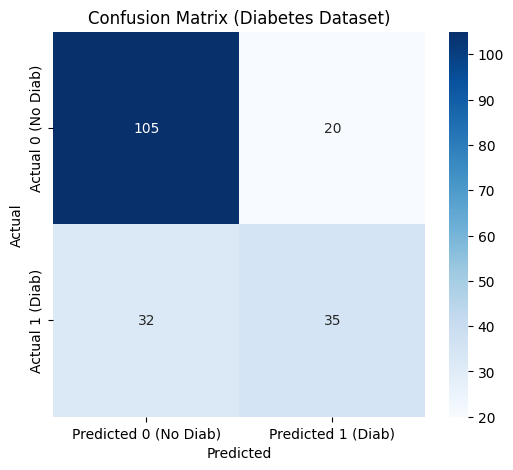


ROC Curve Analysis
Area Under the Curve (AUC): 0.8300


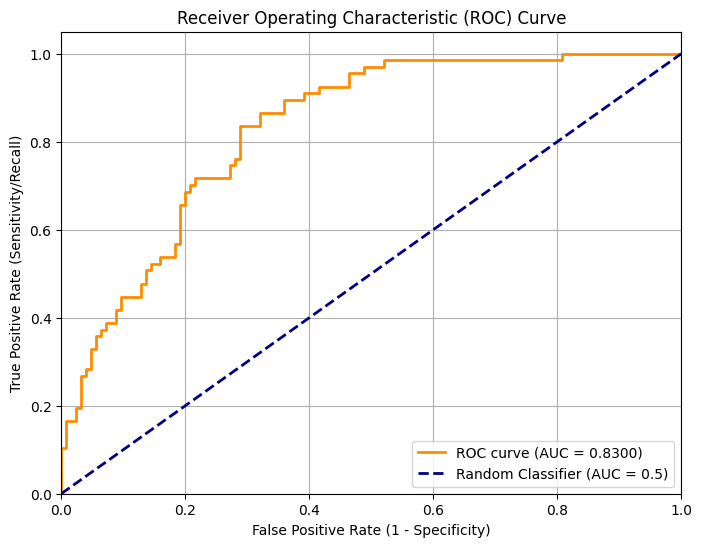

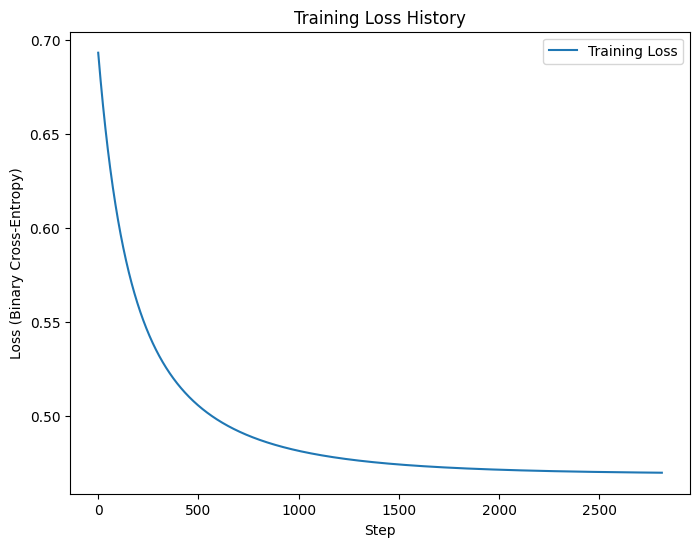

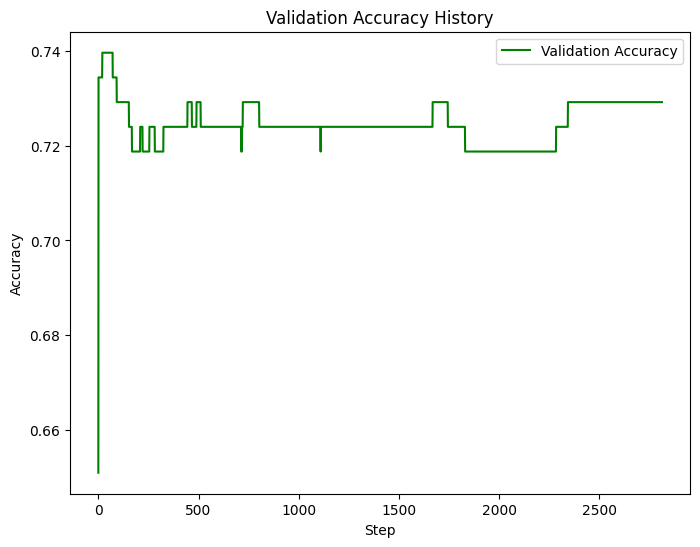


Comprehensive Classification Report (Scikit-learn):
              precision    recall  f1-score   support

 No Diabetes       0.77      0.84      0.80       125
    Diabetes       0.64      0.52      0.57        67

    accuracy                           0.73       192
   macro avg       0.70      0.68      0.69       192
weighted avg       0.72      0.73      0.72       192



In [ ]:
# Plot confusion matrix for diabetes dataset
plt.figure(figsize=(6, 5))
sns.heatmap(cm_new, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0 (No Diab)', 'Predicted 1 (Diab)'],
            yticklabels=['Actual 0 (No Diab)', 'Actual 1 (Diab)'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix (Diabetes Dataset)')
plt.show()

# Plot ROC curve
plot_roc_auc(w_opt_new, X_val_new, y_val_new)

# Plot loss and accuracy histories
plot_training_loss(loss_history_new)
plot_validation_accuracy(val_accuracy_history_new)

print("\nComprehensive Classification Report (Scikit-learn):")
print(classification_report(y_val_new, final_predictions_new, target_names=['No Diabetes', 'Diabetes']))